In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cabm.agent_functions import (
    sample_normal_min,
    sample_beta_min,
    magnitude_adjusted_softmax,
    get_ad_impact_on_purchase_probabilities,
    get_price_impact_on_brand_choice_probabilities,
)

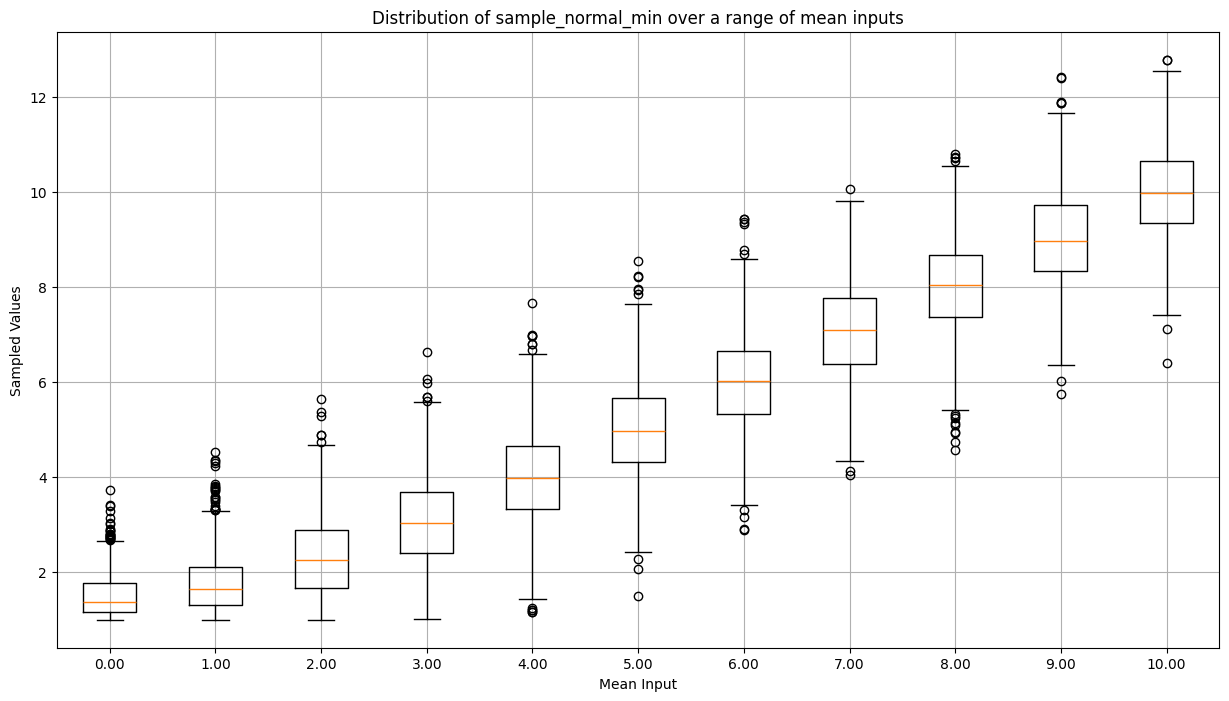

In [2]:
def visualize_sample_normal_min(mean_range, std_dev=1.0, min_value=1.0, override=0, num_samples=1000):
    all_samples = []

    for mean in mean_range:
        mean_samples = [sample_normal_min(mean, std_dev, min_value, override) for _ in range(num_samples)]
        all_samples.append(mean_samples)

    plt.figure(figsize=(15, 8))
    plt.boxplot(all_samples, positions=mean_range, widths=0.5)
    plt.xlabel('Mean Input')
    plt.ylabel('Sampled Values')
    plt.title('Distribution of sample_normal_min over a range of mean inputs')
    plt.grid(True)
    
    # Format x-axis tick labels to show fewer decimal places
    plt.xticks(ticks=mean_range, labels=[f'{mean:.2f}' for mean in mean_range])
    
    plt.show()

# Define the range of mean values
mean_range = [i for i in range(0,11)]

# Visualize the function
visualize_sample_normal_min(mean_range)

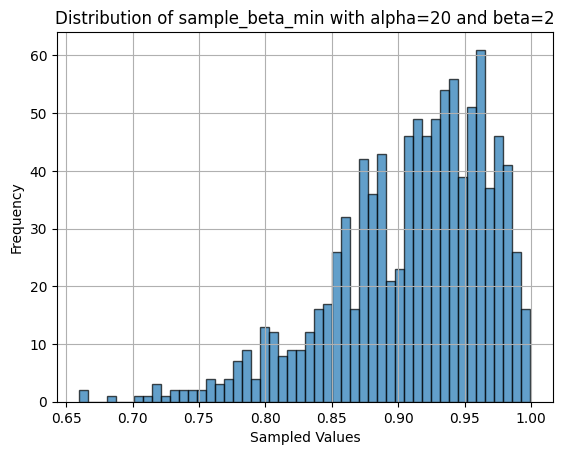

In [3]:
alpha = 20
beta = 2
samps = [sample_beta_min(alpha=alpha,beta=beta) for i in range(1000)]
plt.hist(samps, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Sampled Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of sample_beta_min with alpha={alpha} and beta={beta}')
plt.grid(True)
    
plt.show()

In [4]:
logarithmic_range = np.array([1,10,100,1000,10000,100000,1000000])

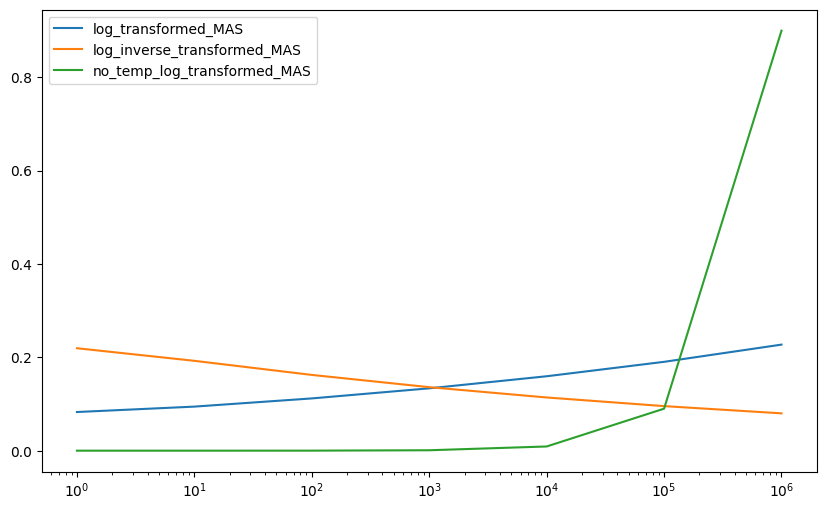

In [7]:
log_transformed_MAS = magnitude_adjusted_softmax(logarithmic_range)
log_inverse_transformed_MAS = magnitude_adjusted_softmax(logarithmic_range, inverse=True)
no_temp_log_transformed_MAS = magnitude_adjusted_softmax(logarithmic_range, magnitude_adjusted_temperature=False)

plt.figure(figsize=(10, 6))
plt.plot(logarithmic_range, log_transformed_MAS, label='log_transformed_MAS')
plt.plot(logarithmic_range, log_inverse_transformed_MAS, label='log_inverse_transformed_MAS')
plt.plot(logarithmic_range, no_temp_log_transformed_MAS, label='no_temp_log_transformed_MAS')
plt.xscale('log')
#plt.yscale('log')
plt.legend()

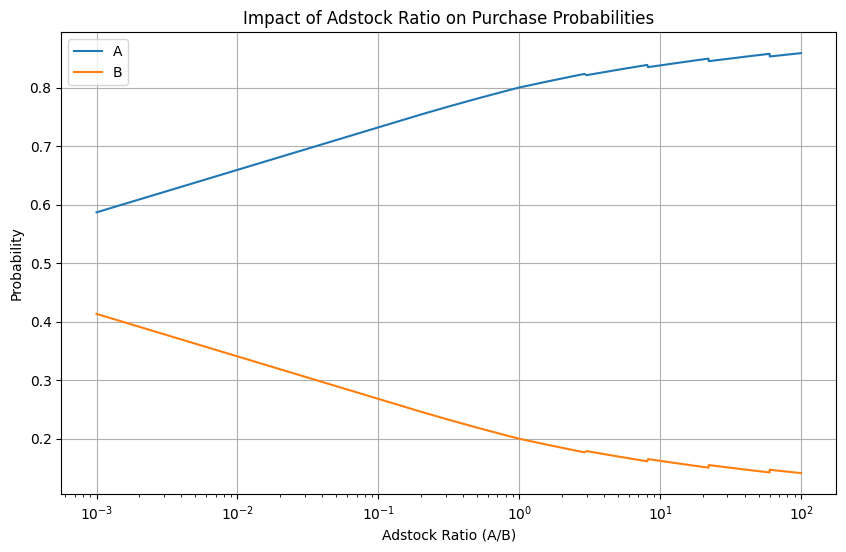

In [8]:
# Define the range for "A" adstock
adstock_A_range = range(1, 100001, 100)

# Initialize lists to store the results
prob_A = []
prob_B = []
adstock_ratios = []  # List to store the adstock ratios

# Iterate over the adstock_A_range
for adstock_A in adstock_A_range:
    adstock_B = 1000
    adstock = {"A": adstock_A, "B": adstock_B}
    brand_preference = "A"
    loyalty_rate = 0.8

    # Get the probabilities
    probabilities = get_ad_impact_on_purchase_probabilities(adstock=adstock, brand_preference=brand_preference, loyalty_rate=loyalty_rate)
    
    # Store the probabilities
    prob_A.append(probabilities['A'])
    prob_B.append(probabilities['B'])

    # Calculate and store the adstock ratio
    adstock_ratios.append(adstock_A / adstock_B)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(adstock_ratios, prob_A, label='A')  # Use adstock_ratios as x-axis values
plt.plot(adstock_ratios, prob_B, label='B')  # Use adstock_ratios as x-axis values
plt.xlabel('Adstock Ratio (A/B)')
plt.xscale('log')
plt.ylabel('Probability')
plt.title('Impact of Adstock Ratio on Purchase Probabilities')
plt.legend()
plt.grid(True)
plt.show()

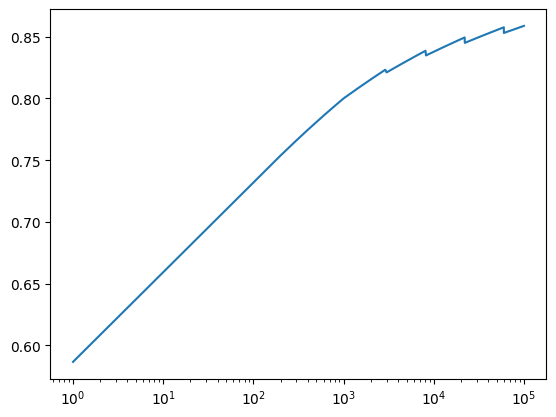

In [17]:
plt.plot(adstock_A_range, prob_A)
plt.xscale('log')

In [24]:
for i in range(len(prob_A)):
    if prob_A[i+1] < prob_A[i]:
        print(i, prob_A[i], prob_A[i+1])

29 0.8232249682121208 0.8210649410231992
81 0.8385776947979934 0.8347955554476756
220 0.8493666950175465 0.844980314859952
598 0.8575756385720406 0.8529926108702997


IndexError: list index out of range

In [30]:
adstocks = [i for i in adstock_A_range]

In [89]:
adstocks[80:83]

[8001, 8101, 8201]

In [36]:
max(1, np.floor(np.log(np.max(8001))))

8.0

In [90]:
vals = [1000,8201]

In [96]:
temp = max(1, np.floor(np.log(np.max(vals))))
print(temp)

9.0


In [92]:
tvals = np.log1p(vals)
print(tvals)

[6.90875478 9.01213331]


In [93]:
atvals = tvals - np.max(tvals)
atvals

array([-2.10337853,  0.        ])

In [94]:
e_x = np.exp(atvals / temp)
print(e_x)

[0.79159235 1.        ]


In [95]:
e_x / np.sum(e_x)

array([0.44183731, 0.55816269])